In [37]:
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from utils import shuffle_batch, variable_summaries
import os

%matplotlib notebook

dir_path = os.getcwd()

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)
print(dir_path)

C:\Users\kicjo\Desktop\my-anns\nuclei-first


In [2]:
df = pd.read_csv("nuclei.csv")
print(df.info())
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 4 columns):
N             3179 non-null int64
Z             3179 non-null int64
D to use      3179 non-null float64
Unnamed: 3    0 non-null float64
dtypes: float64(2), int64(2)
memory usage: 99.4 KB
None


Index(['N', 'Z', 'D to use', 'Unnamed: 3'], dtype='object')

In [3]:
df = df.rename(columns={"D to use": "d", "Z":'z', 'N':'n'})

In [4]:
df = df.drop(df.columns[3], axis='columns')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 3 columns):
n    3179 non-null int64
z    3179 non-null int64
d    3179 non-null float64
dtypes: float64(1), int64(2)
memory usage: 74.6 KB


In [6]:
df.isnull().values.any()

False

In [7]:
df['z'].shape

(3179,)

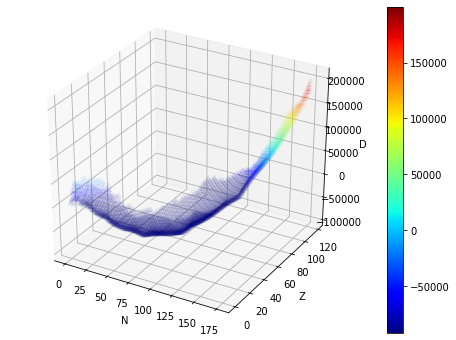

In [8]:
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = df['n']
ys = df['z']
zs = df['d']

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.05)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

3179


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


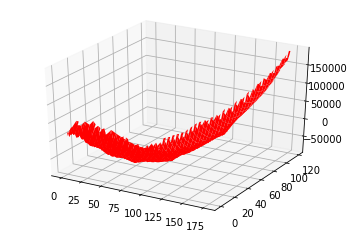

In [9]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

data = list(zip(df['n'],df['z'],df['d']))
print(len(data))
x, y, z = zip(*data)
zs = list(df['d'].to_numpy())

z = list(map(float, z))
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.hsv)
plt.show()

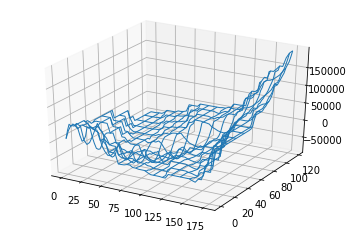

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.interpolate import griddata

x= df['n'].to_numpy()
y= df['z'].to_numpy()
z= df['d'].to_numpy()
fig = plt.figure()
ax = fig.gca(projection='3d')
xi = np.linspace(x.min(), x.max(), 50)
yi = np.linspace(y.min(), y.max(), 50)
zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='nearest')    # create a uniform spaced grid
xig, yig = np.meshgrid(xi, yi)
surf = ax.plot_wireframe(X=xig, Y=yig, Z=zi, rstride=5, cstride=3, linewidth=1,cmap=plt.cm.hsv)   # 3d plot
plt.show()

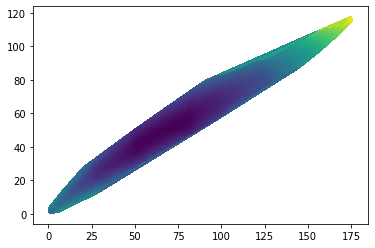

In [11]:
fig, (ax)=plt.subplots(ncols=1)
ax.tripcolor(df["n"], df["z"], df["d"])
#ax2.set_title("tricontour")
#ax2.tricontourf(df["n"], df["z"], df["d"])

plt.show()

In [12]:
x = df.drop('d', axis='columns')
print(x.info())
x = x.to_numpy()
print(x.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3179 entries, 0 to 3178
Data columns (total 2 columns):
n    3179 non-null int64
z    3179 non-null int64
dtypes: int64(2)
memory usage: 49.8 KB
None
(3179, 2)


In [13]:
y = df['d'].to_numpy()
y = y.reshape(-1,1)
y.shape

(3179, 1)

In [14]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(x, y, test_size=0.2, random_state=1)
X_train_o, X_val_o, y_train_o, y_val_o  = train_test_split(X_train_o, y_train_o, test_size=0.2, random_state=1)
n_inputs = X_train_o.shape[1]
n_outputs = y_train_o.shape[1]
print(n_inputs)
print(n_outputs)

2
1


In [15]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = x_scaler.fit_transform(X_train_o.reshape(-1, n_inputs))
X_test = x_scaler.transform(X_test_o.reshape(-1, n_inputs))
X_val = x_scaler.transform(X_val_o.reshape(-1, n_inputs))

y_train = y_scaler.fit_transform(y_train_o.reshape(-1, n_outputs))
y_test = y_scaler.transform(y_test_o.reshape(-1, n_outputs))
y_val = y_scaler.transform(y_val_o.reshape(-1, n_outputs))

n_inputs = X_train.shape[1]
n_outputs = y_train.shape[1]
print(n_inputs)
print(n_outputs)

2
1


In [16]:
def cust_layer(inputs,number_of_neurons, name, activation=None, dropout=False):
    init = tf.initializers.he_normal(seed=None)
    hidden = tf.keras.layers.Dense(number_of_neurons,
                                   name=name,
                                    kernel_initializer=init,
                                   activation = activation,
                                   kernel_regularizer = tf.keras.regularizers.l2(l=0.1)
                                  )(inputs)
    
    batch_norm = tf.keras.layers.BatchNormalization()(hidden, training=True)
    
    if dropout:
        dropout_layer = tf.keras.layers.Dropout(0.5)(batch_norm)
        return dropout_layer
    else:
        return batch_norm
    
tf.reset_default_graph()
with tf.name_scope("dnn"):
    with tf.name_scope("inputs"):
        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")
    
    init = tf.initializers.he_normal(seed=None)    
    hidden1 = tf.keras.layers.Dense(20, name="hidden1",
                                    kernel_initializer=init)(X)    
    batch_norm_1 = tf.keras.layers.BatchNormalization()(hidden1, training=True)    
    dropout1 = tf.keras.layers.Dropout(0.5)(batch_norm_1)
        
    
    last_layer = cust_layer(X,20,"hidden1")
    
    n_layers = 5
    
    for i in range(n_layers):
        is_odd = False
            
        last_layer = cust_layer(last_layer,50,"hidden"+str(i),activation=tf.nn.elu,dropout=True)
   
    
    y_pred = tf.keras.layers.Dense(1, name="output",
                                   kernel_initializer=init)(last_layer)

with tf.name_scope('MSE'):
    error = y_pred - y
    mse = tf.reduce_mean(tf.square(error), name="mse")
    variable_summaries(mse)


with tf.name_scope('optimiser'):
    optimiser = tf.train.AdamOptimizer(0.01)
    training_op = optimiser.minimize(mse)

for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)

W0813 14:41:49.351698 15216 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei-first\utils.py:16: The name tf.summary.scalar is deprecated. Please use tf.compat.v1.summary.scalar instead.

W0813 14:41:49.376010 15216 deprecation_wrapper.py:119] From C:\Users\kicjo\Desktop\my-anns\nuclei-first\utils.py:22: The name tf.summary.histogram is deprecated. Please use tf.compat.v1.summary.histogram instead.



In [17]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(logdir + '/train', tf.get_default_graph())
test_writer = tf.summary.FileWriter(logdir + '/test')
valid_writer = tf.summary.FileWriter(logdir + '/valid')
init = tf.global_variables_initializer()

saver = tf.train.Saver()

checkpoint_path = os.path.join(dir_path, "sinus_tmp","sinus_full_model.ckpt")
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = os.path.join(dir_path, "model", "my_sinus_full_model")

In [18]:
n_epochs = 600
n_batches = 50

best_loss = np.infty
epochs_without_progress = 0
max_epochs_without_progress = n_epochs * 0.4
print(max_epochs_without_progress)



240.0


In [19]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_epoch_path):
        # if the checkpoint file exists, restore the model and load the epoch number
        with open(checkpoint_epoch_path, "rb") as f:
            start_epoch = int(f.read())
        print("Training was interrupted. Continuing at epoch", start_epoch)
        saver.restore(sess, checkpoint_path)
    else:
        start_epoch = 0
        sess.run(init)

    for epoch in range(start_epoch, n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, n_batches):
            summary, _ = sess.run([merged, training_op],
                                  feed_dict={X: X_batch, y: y_batch})

        train_summary, _ = sess.run([merged, training_op],feed_dict={X: X_train, y: y_train})
        test_summary, _ =sess.run([merged, training_op],feed_dict={X: X_test, y: y_test})
        validation_summary, _ = sess.run([merged, training_op], feed_dict={X: X_val, y: y_val})

        train_writer.add_summary(train_summary, epoch)
        test_writer.add_summary(test_summary, epoch)
        valid_writer.add_summary(validation_summary,epoch)

        loss_train = mse.eval(feed_dict={X: X_train, y: y_train})
        loss_val = mse.eval(feed_dict={X: X_val, y: y_val})
        print(epoch, "train loss:", loss_train, "valid loss:", loss_val)

        iteration_skip = 10
        if epoch % iteration_skip == 0:
            saver.save(sess, checkpoint_path)
            with open(checkpoint_epoch_path, "wb") as f:
                f.write(b"%d" % (epoch + 1))

        if loss_val < best_loss:
            saver.save(sess, final_model_path)
            best_loss = loss_val
            print("best loss:", best_loss)
        else:
            epochs_without_progress += 1
            if epochs_without_progress > max_epochs_without_progress:
                print("Early stopping")
                break


train_writer.close()
test_writer.close()
valid_writer.close()

0 train loss: 0.033615958 valid loss: 0.037506595
best loss: 0.037506595
1 train loss: 0.08309978 valid loss: 0.0932734
2 train loss: 0.054341458 valid loss: 0.062199492
3 train loss: 0.032565955 valid loss: 0.03511591
best loss: 0.03511591
4 train loss: 0.024486756 valid loss: 0.02790363
best loss: 0.02790363
5 train loss: 0.04475545 valid loss: 0.053809326
6 train loss: 0.027463697 valid loss: 0.031939603
7 train loss: 0.008464864 valid loss: 0.009935744
best loss: 0.009935744
8 train loss: 0.022436896 valid loss: 0.024299044
9 train loss: 0.023375282 valid loss: 0.022038216
10 train loss: 0.03749491 valid loss: 0.041149084
11 train loss: 0.017389392 valid loss: 0.01664551
12 train loss: 0.0589921 valid loss: 0.048410602
13 train loss: 0.031342603 valid loss: 0.02577536
14 train loss: 0.045041315 valid loss: 0.04989118
15 train loss: 0.017389921 valid loss: 0.023371184
16 train loss: 0.011082848 valid loss: 0.013012956
17 train loss: 0.021642823 valid loss: 0.016974531
18 train loss:

159 train loss: 0.009837651 valid loss: 0.014197895
160 train loss: 0.0066651357 valid loss: 0.009406033
161 train loss: 0.008058846 valid loss: 0.008215102
162 train loss: 0.008399412 valid loss: 0.012889203
163 train loss: 0.006616328 valid loss: 0.009029192
164 train loss: 0.017542465 valid loss: 0.025025276
165 train loss: 0.017803118 valid loss: 0.023500383
166 train loss: 0.009503816 valid loss: 0.01124059
167 train loss: 0.013422818 valid loss: 0.018333403
168 train loss: 0.010465238 valid loss: 0.01703525
169 train loss: 0.012743486 valid loss: 0.013651846
170 train loss: 0.015073731 valid loss: 0.020909162
171 train loss: 0.0075149895 valid loss: 0.013393697
172 train loss: 0.019501476 valid loss: 0.024637047
173 train loss: 0.03456501 valid loss: 0.036111683
174 train loss: 0.008707029 valid loss: 0.013757656
175 train loss: 0.0109663885 valid loss: 0.01719876
176 train loss: 0.013783611 valid loss: 0.018299803
177 train loss: 0.008561345 valid loss: 0.0068782596
178 train lo

In [20]:
os.remove(checkpoint_epoch_path)

In [21]:
with tf.Session() as sess:
    saver.restore(sess, final_model_path)
    test_mse = mse.eval(feed_dict={X: X_test, y: y_test})
    predictions = y_pred.eval(feed_dict={X: X_test, y: y_test})
    
    
print(test_mse)

W0813 14:42:38.843721 15216 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


0.011721175


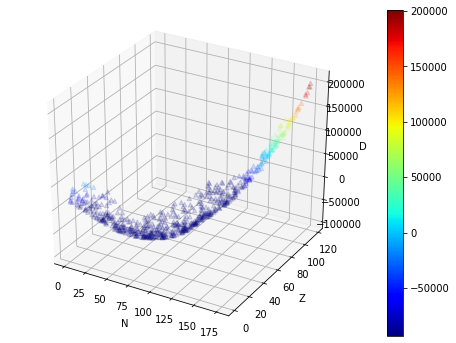

In [22]:
y_new_inverse = y_scaler.inverse_transform(predictions)
x_test_inverse = x_scaler.inverse_transform(X_test)

fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = y_new_inverse[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.15)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [23]:
diff = (y_new_inverse - y_test_o) / y_test_o
diff_abs = y_new_inverse - y_test_o
print(diff[:5])
reshaped_diff = diff.reshape(-1,1)[:,0]
print(reshaped_diff.shape)
print(reshaped_diff[:5])

[[-0.10842589]
 [ 0.013972  ]
 [ 0.28389683]
 [ 0.17912578]
 [-0.05217601]]
(636,)
[-0.10842589  0.013972    0.28389683  0.17912578 -0.05217601]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


In [24]:
df = pd.DataFrame(data={'diff': reshaped_diff})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 1 columns):
diff    636 non-null float64
dtypes: float64(1)
memory usage: 5.0 KB


In [25]:
df.isnull().values.any()

False

In [26]:
df.max()

diff    inf
dtype: float64

In [27]:
#df = df.replace([np.inf, -np.inf], 0)

In [28]:
df.describe()

,diff
count,636.000000
mean,inf
std,NaN
min,-55.682085
25%,-0.080596
50%,0.027077
75%,0.100707
max,inf


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


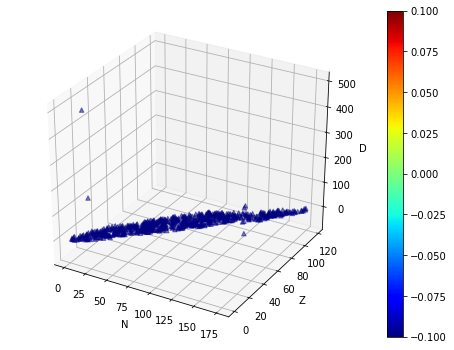

In [29]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111,projection='3d')

xs = x_test_inverse[:,0]
ys = x_test_inverse[:,1]
zs = diff[:,0]

colmap = cm.ScalarMappable(cmap=cm.get_cmap("jet"))
colmap.set_array(zs)

yg = ax.scatter(xs, ys, zs, c=cm.get_cmap("jet")(zs/max(zs)), marker='^',alpha=0.5)
cb = fig.colorbar(colmap)

ax.set_xlabel('N')
ax.set_ylabel('Z')
ax.set_zlabel('D')


plt.show()

In [30]:
range_x = x_test_inverse.shape[0]
range_x

636

In [31]:
iterate_x = list(range(0,range_x))
len(iterate_x)

636

In [32]:
diff[:,0].shape

(636,)

In [40]:
y_new_inverse [78]

array([-8615.142], dtype=float32)

In [41]:
y_test_o[78]

array([-17.404])

In [42]:
X_test_o[78]

array([11,  9], dtype=int64)

<IPython.core.display.Javascript object>


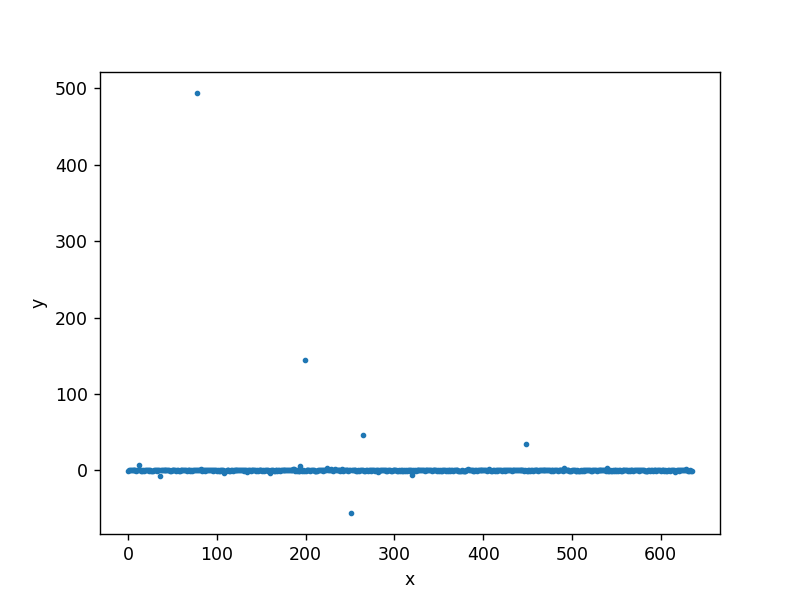

In [38]:
plt.scatter(iterate_x, diff[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

In [39]:
df.describe()

,diff
count,636.000000
mean,inf
std,NaN
min,-55.682085
25%,-0.080596
50%,0.027077
75%,0.100707
max,inf


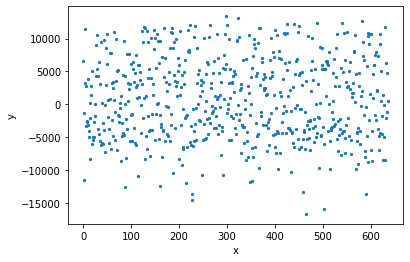

In [34]:
plt.scatter(iterate_x, diff_abs[:,0], s=5)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.show()

array([53904.254], dtype=float32)

array([59364.01])